In [1]:
%matplotlib inline

import numpy as np
import statsmodels.api as sm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, HTML

/Users/megh/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/megh/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('./data/final_regression_dataset.csv')
# remove asins
data = data.drop('ASIN',axis=1)
# one hot encoding for any categorical vars
data = pd.get_dummies(data)
y = data.loc[:, data.columns == 'salesRank']
x = data.loc[:, data.columns != 'salesRank']
# split 75% for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

## Linear Regression
# instantiate
linreg = LinearRegression()
# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)
    
# make predictions on the testing set
y_pred = linreg.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("RMSE in terms of sales rank = ",rmse)

(15179, 404) (15179, 1) (5060, 404) (5060, 1)
RMSE in terms of sales rank =  56238.570953


In [4]:
# get p-values for all the features
est = sm.OLS(y, x)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              salesRank   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     2.989
Date:                Tue, 01 May 2018   Prob (F-statistic):           1.92e-77
Time:                        11:34:54   Log-Likelihood:            -2.4947e+05
No. Observations:               20239   AIC:                         4.997e+05
Df Residuals:                   19835   BIC:                         5.029e+05
Df Model:                         403                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [6]:
# try again with log sales rank as the target variable
data = pd.read_csv('./data/final_regression_dataset.csv')
# remove asins
data = data.drop('ASIN',axis=1)
# one hot encoding for any categorical vars
data = pd.get_dummies(data)
y = data.loc[:, data.columns == 'salesRank']
# apply log to the sales rank column
y = y.apply(np.log)
# keep rest of the variables as it is
x = data.loc[:, data.columns != 'salesRank']

# rerun linear regression
# split 75% for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

## Linear Regression
# instantiate
linreg = LinearRegression()
# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)    
# make predictions on the testing set
y_pred = linreg.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("RMSE in terms of log(sales rank) = ",rmse)
print("in terms of normal sales rank this is = ", np.e**(rmse))

RMSE in terms of log(sales rank) =  1.5056961221
in terms of normal sales rank this is =  4.50729016277


In [8]:
# get p-values for all the features
est = sm.OLS(y, x)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              salesRank   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     3.473
Date:                Tue, 01 May 2018   Prob (F-statistic):          5.93e-105
Time:                        11:39:42   Log-Likelihood:                -36190.
No. Observations:               20239   AIC:                         7.319e+04
Df Residuals:                   19835   BIC:                         7.639e+04
Df Model:                         403                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [9]:
# Now run lasso for feature selection
def lasso_regression(x, y, alpha, max_iter):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=max_iter)
    lassoreg.fit(x,y)
    y_pred = lassoreg.predict(x)
    
    #Return the result in pre-defined format
    rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
    ret = [rmse]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

In [181]:
# Define the alpha values to test with
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

# Make the dataframe to store coefficients
cols = ['rmse','intercept'] + ['coef_'+name for name in x.columns.tolist()]
inds = ['alpha_%.2g'%alpha_lasso[i] for i in range(len(alpha_lasso))]
coef_matrix_lasso = pd.DataFrame(index=inds, columns=cols)
#Iterate over the alpha values and run Lasso:
for i in range(len(alpha_lasso)):
    coef_matrix_lasso.iloc[i,] = lasso_regression(x, y, alpha_lasso[i],10000)
# coef_matrix_lasso.to_csv("./data/coef_matrix_lasso.csv")
s1 = coef_matrix_lasso["rmse"]
s2 = (coef_matrix_lasso == 0).astype(int).sum(axis=1)
df = pd.concat([s1, s2], axis=1)
df.columns = ["rmse","features removed"]
df

/Users/megh/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,rmse,features removed
alpha_1e-15,1.44656,0
alpha_1e-10,1.44656,0
alpha_1e-08,1.44656,1
alpha_1e-05,1.44726,50
alpha_0.0001,1.46173,299
alpha_0.001,1.49673,404
alpha_0.01,1.49673,404
alpha_1,1.49673,404
alpha_5,1.49673,404
alpha_10,1.49673,404


In [9]:
# we see that alpha = 0.0001 removes 299 features,
# while maintaining an RMSE of 1.46
# and keeps 100 lets explore with alpha values around 0.0001
# Define the new alpha values
alpha_lasso = [0.00002, 0.00004, 0.00008, 0.00010 ,0.00015, 
               0.0002, 0.0004, 0.0006, 0.0008, 0.0009]

# Make the dataframe to store coefficients
cols = ['rmse','intercept'] + ['coef_'+name for name in x.columns.tolist()]
inds = ['alpha_%.2g'%alpha_lasso[i] for i in range(len(alpha_lasso))]
coef_matrix_lasso = pd.DataFrame(index=inds, columns=cols)
#Iterate over the alpha values and run Lasso:
for i in range(len(alpha_lasso)):
    coef_matrix_lasso.iloc[i,] = lasso_regression(x, y, alpha_lasso[i],10000)
#coef_matrix_lasso.to_csv("./data/coef_matrix_lasso_2.csv")
s1 = coef_matrix_lasso["rmse"]
s2 = (coef_matrix_lasso == 0).astype(int).sum(axis=1)
df = pd.concat([s1, s2], axis=1)
df.columns = ["rmse","features removed"]
df

,rmse,features removed
alpha_2e-05,1.44883,101
alpha_4e-05,1.4524,181
alpha_8e-05,1.45882,266
alpha_0.0001,1.46173,299
alpha_0.00015,1.468,345
alpha_0.0002,1.47268,369
alpha_0.0004,1.48249,397
alpha_0.0006,1.48884,402
alpha_0.0008,1.49245,402
alpha_0.0009,1.49464,402


In [15]:
# for alpha = 0.00008 we get RMSE = 1.45 while removing 266 features
# Lets look at the features not removed by Lasso

data = pd.read_csv('./data/final_regression_dataset.csv')
# remove asins
data = data.drop('ASIN',axis=1)
# one hot encoding for any categorical vars
data = pd.get_dummies(data)
y = data.loc[:, data.columns == 'salesRank']
# apply log to the sales rank column
y = y.apply(np.log)
# keep rest of the variables as it is
x = data.loc[:, data.columns != 'salesRank']
names = x.columns.tolist()
lasso = Lasso(alpha=0.00008,normalize=True, max_iter=10000)
lasso.fit(x, y)
y_pred = lasso.predict(x)

rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
print("RMSE in terms of log(sales rank) = ",rmse)
print("in terms of normal sales rank this is = ", np.e**(rmse))
print("No. of features selected =",len(goodFeaturesDict))
goodFeaturesDict = {}
for n,c in zip(names, lasso.coef_):
    if c != 0.0:
        goodFeaturesDict[n] = c
# get the top and bottom 10 features by coefficients
good_features_df = pd.DataFrame.from_dict(goodFeaturesDict,orient='index')
good_features_df = good_features_df.sort_values(by=0,ascending=False)
good_features_df.columns = ["Coefficient"]
display(good_features_df.head(20))
display(good_features_df.tail(20))

RMSE in terms of log(sales rank) =  1.45882400431
in terms of normal sales rank this is =  4.30089871484
No. of features selected = 138


,Coefficient
empath_description_crime,11.481387
empath_description_politics,10.723809
empath_review_art,7.041872
empath_description_art,6.650919
empath_description_wedding,5.466484
empath_review_pride,4.901149
empath_review_internet,4.366399
empath_description_heroic,4.064119
empath_review_gain,3.913187
empath_description_anger,3.753240


,Coefficient
empath_description_war,-2.759917
empath_description_musical,-3.030058
empath_review_alcohol,-3.091262
empath_description_exotic,-3.139496
empath_review_morning,-3.180424
empath_description_masculine,-3.246498
empath_description_beach,-3.283715
empath_description_communication,-3.286003
empath_review_play,-3.510176
empath_description_school,-3.598771


In [22]:
# split the last 20 empath features which reduce the salesrank the most
# 
bottom_20 = good_features_df.tail(20)
review_features = []
description_features = []
for i,r in bottom_20.iterrows():
    if i.split("_")[1] == "description":
        description_features.append(i)
    elif i.split("_")[1] == "review":
        review_features.append(i)
            
good_desc_features = bottom_20.loc[description_features].sort_values(by="Coefficient")
print("All product description Empath categories that determine sales rank",good_desc_features.shape)
display(good_desc_features)

good_rev_features = bottom_20.loc[review_features].sort_values(by="Coefficient")
print("All product review Empath categories that determine sales rank",good_rev_features.shape)
display(good_rev_features)

All product description Empath categories that determine sales rank (11, 1)


,Coefficient
empath_description_confusion,-7.970729
empath_description_worship,-7.133864
empath_description_vehicle,-6.475228
empath_description_gain,-3.638916
empath_description_school,-3.598771
empath_description_communication,-3.286003
empath_description_beach,-3.283715
empath_description_masculine,-3.246498
empath_description_exotic,-3.139496
empath_description_musical,-3.030058


All product review Empath categories that determine sales rank (9, 1)


,Coefficient
empath_review_politics,-7.663487
empath_review_anticipation,-6.295648
empath_review_ridicule,-6.225872
empath_review_stealing,-5.228609
empath_review_occupation,-4.470087
empath_review_fight,-3.725816
empath_review_play,-3.510176
empath_review_morning,-3.180424
empath_review_alcohol,-3.091262


In [20]:
# Split all the empath features by reviews and descriptions
review_features = []
description_features = []
for i,r in good_features_df.iterrows():
    if i.split("_")[0] == "empath":
        if i.split("_")[1] == "description":
            description_features.append(i)
        elif i.split("_")[1] == "review":
            review_features.append(i)
            
good_desc_features = good_features_df.loc[description_features].sort_values(by="Coefficient",ascending=False)
print("All product description Empath categories that determine sales rank",good_desc_features.shape)
display(good_desc_features)

good_rev_features = good_features_df.loc[review_features].sort_values(by="Coefficient",ascending=False)
print("All product review Empath categories that determine sales rank",good_rev_features.shape)
display(good_rev_features)

All product description Empath categories that determine sales rank (76, 1)


,Coefficient
empath_description_crime,11.481387
empath_description_politics,10.723809
empath_description_art,6.650919
empath_description_wedding,5.466484
empath_description_heroic,4.064119
empath_description_anger,3.753240
empath_description_movement,3.704169
empath_description_writing,3.471974
empath_description_attractive,3.419211
empath_description_order,3.394852


All product review Empath categories that determine sales rank (55, 1)


,Coefficient
empath_review_art,7.041872
empath_review_pride,4.901149
empath_review_internet,4.366399
empath_review_gain,3.913187
empath_review_fabric,2.454295
empath_review_clothing,2.087302
empath_review_politeness,1.926930
empath_review_feminine,1.914000
empath_review_leisure,1.744264
empath_review_cooking,1.533555


In [23]:
# get p-values for the features
# keep the good features only
x2 = x[good_features_df.index.tolist()]
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              salesRank   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     2928.
Date:                Tue, 01 May 2018   Prob (F-statistic):               0.00
Time:                        12:20:54   Log-Likelihood:                -43767.
No. Observations:               20239   AIC:                         8.781e+04
Df Residuals:                   20101   BIC:                         8.890e+04
Df Model:                         138                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [24]:
# only use the top 67 empath features
# get the p-values and RMSE
x2 = x[good_features_df.head(67).index.tolist()]

# rerun linear regression
# split 75% for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(x2, y, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

## Linear Regression
# instantiate
linreg = LinearRegression()
# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)    
# make predictions on the testing set
y_pred = linreg.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("RMSE in terms of log(sales rank) = ",rmse)
print("in terms of normal sales rank this is = ", np.e**(rmse))

(15179, 67) (15179, 1) (5060, 67) (5060, 1)
RMSE in terms of log(sales rank) =  1.50806453264
in terms of normal sales rank this is =  4.51797792779


In [25]:
# get the p-values and RMSE
x2 = x[good_features_df.head(67).index.tolist()]
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              salesRank   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     1929.
Date:                Tue, 01 May 2018   Prob (F-statistic):               0.00
Time:                        12:22:28   Log-Likelihood:                -54363.
No. Observations:               20239   AIC:                         1.089e+05
Df Residuals:                   20172   BIC:                         1.094e+05
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [26]:
# Lets look at the non-emapth features that didn't vanish after lasso
non_empath_features = []
for f in [*goodFeaturesDict.keys()]:
    if f.split("_")[0] != "empath":
        non_empath_features.append(f)
print("There are", len(non_empath_features), "non-Empath features")
good_non_empth_features = good_features_df.loc[non_empath_features].sort_values(by="Coefficient",ascending=False)
good_non_empth_features

There are 7 non-Empath features


,Coefficient
category_Health & Personal Care,0.341056
category_Sports &amp; Outdoors,0.290112
reviewSentimentCom,0.091728
price,0.006680
readabilityIndexDescription,0.002919
Rating,-0.060624
category_Grocery & Gourmet Food,-0.082121


In [17]:
# Lets ignore all empath features and see what happens?
all_non_empath_features = []
for f in x.columns.tolist():
    if f.split("_")[0] != "empath":
        all_non_empath_features.append(f)
ne_x = x[all_non_empath_features] 

est = sm.OLS(y, ne_x)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              salesRank   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     35.57
Date:                Mon, 30 Apr 2018   Prob (F-statistic):          1.19e-102
Time:                        00:40:09   Log-Likelihood:                -36616.
No. Observations:               20239   AIC:                         7.326e+04
Df Residuals:                   20223   BIC:                         7.339e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
readabilit

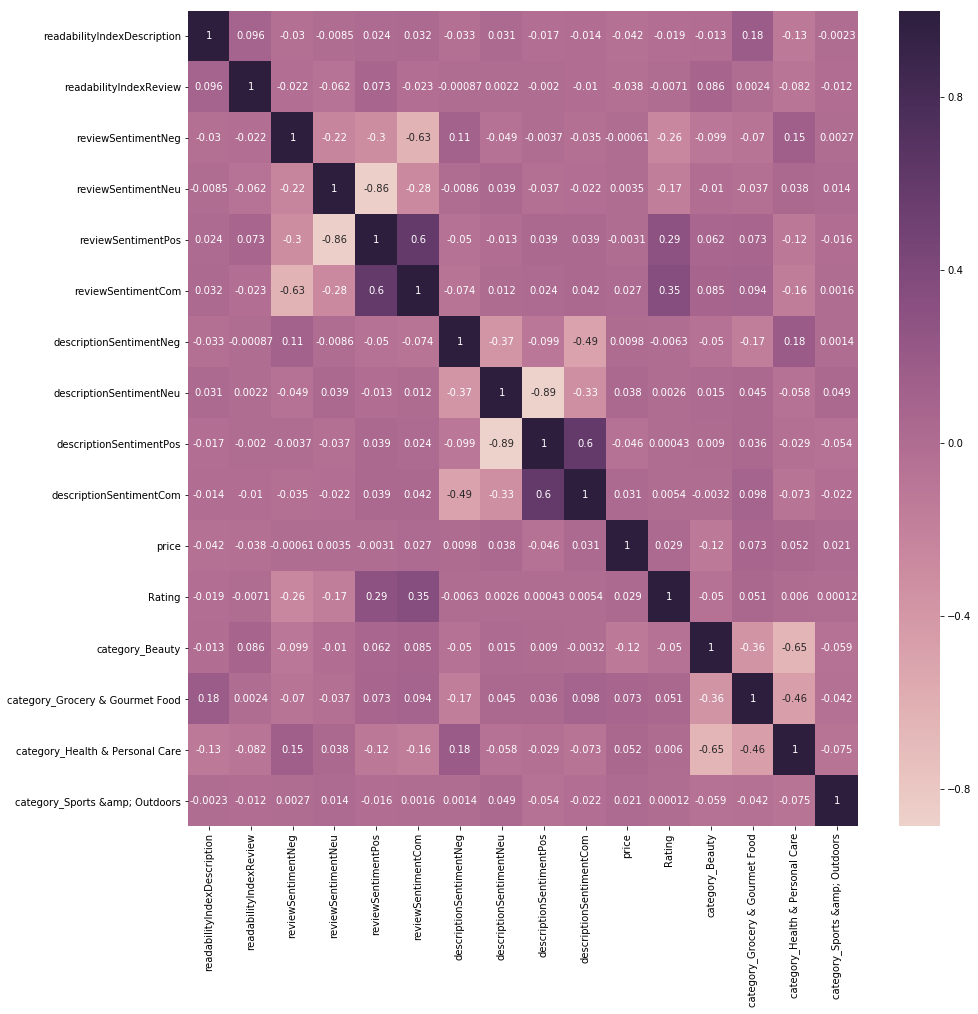

In [26]:
# lets look at what features are correlated
cm = sns.cubehelix_palette(as_cmap=True)
plt.figure(figsize = (15,15))
sns.heatmap(ne_x.corr(),annot=True,cmap=cm)

In [29]:
# categories look negatively correlated (Beauty and Health & Personal Care)
# description sentiment positive seems negatively correlated with description sentiment neutral
# review sentiment compound and positive seem correlated with each other
# review sentiment positive and neutral seem negatively correlated with each other
# !! so lets remove the categories, compund and neutral sentiment features of reviews and descriptions
selected_features = [
                    'readabilityIndexDescription', 'readabilityIndexReview', 'reviewSentimentNeg', 
                    'reviewSentimentPos', 'descriptionSentimentNeg', 'descriptionSentimentPos', 'price', 
                    'Rating'
                    ]
# rerun linear regression
ne_x2 = x[selected_features] 
est = sm.OLS(y, ne_x2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              salesRank   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 6.776e+04
Date:                Mon, 30 Apr 2018   Prob (F-statistic):               0.00
Time:                        01:02:40   Log-Likelihood:                -40979.
No. Observations:               20239   AIC:                         8.197e+04
Df Residuals:                   20231   BIC:                         8.204e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
readabilityIndexDe

In [30]:
# Define the alpha values to test with
alpha_lasso = [1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

# Make the dataframe to store coefficients
cols = ['rmse','intercept'] + ['coef_'+name for name in ne_x2.columns.tolist()]
inds = ['alpha_%.2g'%alpha_lasso[i] for i in range(len(alpha_lasso))]
coef_matrix_lasso = pd.DataFrame(index=inds, columns=cols)
#Iterate over the alpha values and run Lasso:
for i in range(len(alpha_lasso)):
    coef_matrix_lasso.iloc[i,] = lasso_regression(ne_x2, y, alpha_lasso[i],10000)
# coef_matrix_lasso.to_csv("./data/coef_matrix_lasso.csv")
s1 = coef_matrix_lasso["rmse"]
s2 = (coef_matrix_lasso == 0).astype(int).sum(axis=1)
df = pd.concat([s1, s2], axis=1)
df.columns = ["rmse","features removed"]
df

,rmse,features removed
alpha_1e-10,1.48658,0
alpha_1e-08,1.48658,0
alpha_1e-05,1.48659,1
alpha_0.0001,1.48705,3
alpha_0.001,1.49673,8
alpha_0.01,1.49673,8
alpha_1,1.49673,8
alpha_5,1.49673,8
alpha_10,1.49673,8


In [32]:
# feature selection using lasso
names = ne_x2.columns.tolist()
lasso = Lasso(alpha=0.0001,normalize=True, max_iter=10000)
lasso.fit(ne_x2, y)
y_pred = lasso.predict(ne_x2)

rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
print("RMSE in terms of log(sales rank) = ",rmse)
print("in terms of normal sales rank this is = ", np.e**(rmse))
goodFeaturesDict = {}
for n,c in zip(names, lasso.coef_):
    if c != 0.0:
        goodFeaturesDict[n] = c

good_features_df = pd.DataFrame.from_dict(goodFeaturesDict,orient='index')
good_features_df = good_features_df.sort_values(by=0,ascending=False)
good_features_df.columns = ["Coefficient"]
good_features_df

RMSE in terms of log(sales rank) =  1.48705235537
in terms of normal sales rank this is =  4.42403579541


,Coefficient
descriptionSentimentNeg,0.120925
price,0.006353
readabilityIndexDescription,0.002860
readabilityIndexReview,-0.000051
Rating,-0.049363


In [34]:
# rerun linear regression with the new features
ne_x3 = ne_x2[good_features_df.index.tolist()] 
est = sm.OLS(y, ne_x3)
est2 = est.fit()
print(est2.summary())
y_pred = est2.predict()

                            OLS Regression Results                            
Dep. Variable:              salesRank   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                 1.031e+05
Date:                Mon, 30 Apr 2018   Prob (F-statistic):               0.00
Time:                        01:14:38   Log-Likelihood:                -41475.
No. Observations:               20239   AIC:                         8.296e+04
Df Residuals:                   20234   BIC:                         8.300e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
descriptionSentime

In [6]:
# Lets ignore all non-empath features
all_empath_features = []
for f in x.columns.tolist():
    if f.split("_")[0] == "empath":
        all_empath_features.append(f)
e_x = x[all_empath_features] 

est = sm.OLS(y, e_x)
est2 = est.fit()
print(est2.summary())
y_pred = est2.predict()
rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
print("RMSE in terms of log(sales rank) = ",rmse)
print("in terms of normal sales rank this is = ", np.e**(rmse))

                            OLS Regression Results                            
Dep. Variable:              salesRank   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     461.3
Date:                Mon, 30 Apr 2018   Prob (F-statistic):               0.00
Time:                        01:25:42   Log-Likelihood:                -51308.
No. Observations:               20239   AIC:                         1.034e+05
Df Residuals:                   19851   BIC:                         1.065e+05
Df Model:                         388                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [9]:
# Define the alpha values to test with
alpha_lasso = [1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

# Make the dataframe to store coefficients
cols = ['rmse','intercept'] + ['coef_'+name for name in e_x.columns.tolist()]
inds = ['alpha_%.2g'%alpha_lasso[i] for i in range(len(alpha_lasso))]
coef_matrix_lasso = pd.DataFrame(index=inds, columns=cols)
#Iterate over the alpha values and run Lasso:
for i in range(len(alpha_lasso)):
    coef_matrix_lasso.iloc[i,] = lasso_regression(e_x, y, alpha_lasso[i],10000)
# coef_matrix_lasso.to_csv("./data/coef_matrix_lasso.csv")
s1 = coef_matrix_lasso["rmse"]
s2 = (coef_matrix_lasso == 0).astype(int).sum(axis=1)
df = pd.concat([s1, s2], axis=1)
df.columns = ["rmse","features removed"]
df

,rmse,features removed
alpha_1e-10,1.46695,0
alpha_1e-08,1.46695,0
alpha_1e-05,1.46763,41
alpha_0.0001,1.48109,283
alpha_0.001,1.49673,388
alpha_0.01,1.49673,388
alpha_1,1.49673,388
alpha_5,1.49673,388
alpha_10,1.49673,388


In [16]:
# feature selection using lasso
names = e_x.columns.tolist()
lasso = Lasso(alpha=0.0001,normalize=True, max_iter=10000)
lasso.fit(e_x, y)
y_pred = lasso.predict(e_x)

rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
print("RMSE in terms of log(sales rank) = ",rmse)
print("in terms of normal sales rank this is = ", np.e**(rmse))
goodFeaturesDict = {}
for n,c in zip(names, lasso.coef_):
    if c != 0.0:
        goodFeaturesDict[n] = c

good_features_df = pd.DataFrame.from_dict(goodFeaturesDict,orient='index')
good_features_df = good_features_df.sort_values(by=0,ascending=False)
good_features_df.columns = ["Coefficient"]
good_features_df

RMSE in terms of log(sales rank) =  1.4810898477
in terms of normal sales rank this is =  4.39773593252


,Coefficient
empath_description_politics,9.313542
empath_description_crime,6.829226
empath_review_internet,4.842390
empath_review_art,4.817250
empath_description_art,4.749265
empath_description_movement,4.739913
empath_description_writing,4.393891
empath_description_anger,4.236004
empath_review_gain,3.543052
empath_description_clothing,3.490308


In [17]:
# lets split these features by reviews and descriptions
description_features = []
review_features = []
for i,r in good_features_df.iterrows():
    if i.split("_")[1] == "description":
        description_features.append(i)
    elif i.split("_")[1] == "review":
        review_features.append(i)
print("Top product description Empath categories that determine sales rank",len(description_features))
good_desc_features = good_features_df.loc[description_features].sort_values(by="Coefficient",ascending=False)
display(good_desc_features)

print("Top product review Empath categories that determine sales rank",len(review_features))
good_rev_features = good_features_df.loc[review_features].sort_values(by="Coefficient",ascending=False)
display(good_rev_features)

Top product description Empath categories that determine sales rank 62


,Coefficient
empath_description_politics,9.313542
empath_description_crime,6.829226
empath_description_art,4.749265
empath_description_movement,4.739913
empath_description_writing,4.393891
empath_description_anger,4.236004
empath_description_clothing,3.490308
empath_description_wedding,3.218809
empath_description_attractive,2.482583
empath_description_order,2.456902


Top product review Empath categories that determine sales rank 43


,Coefficient
empath_review_internet,4.842390
empath_review_art,4.817250
empath_review_gain,3.543052
empath_review_pride,3.370365
empath_review_clothing,2.481782
empath_review_journalism,2.099309
empath_review_pet,1.633785
empath_review_movement,1.509895
empath_review_fabric,1.405604
empath_review_strength,1.339339


In [18]:
# rerun linear regression with the selected features
e_x2 = e_x[good_features_df.index.tolist()] 
est = sm.OLS(y, e_x2)
est2 = est.fit()
print(est2.summary())
y_pred = est2.predict()
rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
print("RMSE in terms of log(sales rank) = ",rmse)
print("in terms of normal sales rank this is = ", np.e**(rmse))

                            OLS Regression Results                            
Dep. Variable:              salesRank   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     975.8
Date:                Mon, 30 Apr 2018   Prob (F-statistic):               0.00
Time:                        01:55:17   Log-Likelihood:                -56345.
No. Observations:               20239   AIC:                         1.129e+05
Df Residuals:                   20134   BIC:                         1.137e+05
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [ ]:
# # lets try dropping the category columns and run Lasso again
# cat_cols = ['category_Beauty', 'category_Grocery & Gourmet Food', 
#                       'category_Health & Personal Care', 'category_Sports &amp; Outdoors']
# x_noncat = x.drop(cat_cols,axis=1)

# # split 75% for training and 25% for testing
# X_train, X_test, y_train, y_test = train_test_split(x_noncat, y, random_state=1)

# ## Linear Regression
# # instantiate
# linreg = LinearRegression()
# # fit the model to the training data (learn the coefficients)
# linreg.fit(X_train, y_train)    
# # make predictions on the testing set
# y_pred = linreg.predict(X_test)
# rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
# print("RMSE in terms of log(sales rank) = ",rmse)
# print("in terms of normal sales rank this is = ", np.e**(rmse))
# print("Coefficient of determination R^2 of the prediction = ", linreg.score(x_noncat,y))
# # feature selection using lasso
# names = x_noncat.columns.tolist()
# lasso = Lasso(alpha=0.0001,normalize=True, max_iter=10000)
# lasso.fit(x_noncat, y)
# y_pred = lasso.predict(x_noncat)

# rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
# print("RMSE in terms of log(sales rank) = ",rmse)
# print("in terms of normal sales rank this is = ", np.e**(rmse))

# goodFeaturesDict = {}
# for n,c in zip(names, lasso.coef_):
#     if c != 0.0:
#         goodFeaturesDict[n] = c
# # get the top 25 features by coefficients
# good_features_df = pd.DataFrame.from_dict(goodFeaturesDict,orient='index')
# good_features_df = good_features_df.sort_values(by=0,ascending=False)
# good_features_df.columns = ["Coefficient"]
# good_features_df.head(25)

In [19]:
# lets split by categories and run the regression on individual category data
# compute the number of data points in each category
data = pd.read_csv('./data/final_regression_dataset.csv')
# remove asins
data = data.drop('ASIN',axis=1)
# one hot encoding for the category vars
data = pd.get_dummies(data)

# compute individual dataframes for each category
beauty_data = data.loc[data['category_Beauty'] == 1]
grocery_data = data.loc[data['category_Grocery & Gourmet Food'] == 1]
health_data = data.loc[data['category_Health & Personal Care'] == 1]
sports_data = data.loc[data['category_Sports &amp; Outdoors'] == 1]
print(beauty_data.shape,grocery_data.shape,health_data.shape,sports_data.shape)

(6857, 405) (4156, 405) (9088, 405) (138, 405)


In [34]:
def find_imp_features_for_cat(cat):
    data = pd.read_csv('./data/final_regression_dataset.csv')
    # remove asins
    data = data.drop('ASIN',axis=1)
    # one hot encoding for the category vars
    data = pd.get_dummies(data)

    # compute individual dataframes for each category
    category_data = data.loc[data[cat] == 1]
    print(category_data.shape)
    # apply log to the sales rank column
    y = category_data.loc[:, category_data.columns == 'salesRank']
    y = y.apply(np.log)

    x = category_data.loc[:, category_data.columns != 'salesRank']
    # drop the category columns as it's all ones now
    cat_cols = ['category_Beauty', 'category_Grocery & Gourmet Food', 
                          'category_Health & Personal Care', 'category_Sports &amp; Outdoors']
    x = x.drop(cat_cols,axis=1)

    # Ignore all non-empath features
    all_empath_features = []
    for f in x.columns.tolist():
        if f.split("_")[0] == "empath":
            all_empath_features.append(f)
    e_x = x[all_empath_features] 

    est = sm.OLS(y, e_x)
    est2 = est.fit()
    #print(est2.summary())
    y_pred = est2.predict()
    rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
    print("RMSE in terms of log(sales rank) = ",rmse)
    print("in terms of normal sales rank this is = ", np.e**(rmse))

    # now run Lasso and find important features
    names = e_x.columns.tolist()
    lasso = Lasso(alpha=0.0001,normalize=True, max_iter=10000)
    lasso.fit(e_x, y)
    y_pred = lasso.predict(e_x)

    rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
    print("RMSE in terms of log(sales rank) = ",rmse)
    print("in terms of normal sales rank this is = ", np.e**(rmse))

    goodFeaturesDict = {}
    for n,c in zip(names, lasso.coef_):
        if c != 0.0:
            goodFeaturesDict[n] = c

    # get the top 25 features by coefficients
    good_features_df = pd.DataFrame.from_dict(goodFeaturesDict,orient='index')
    good_features_df = good_features_df.sort_values(by=0,ascending=False)
    good_features_df.columns = ["Coefficient"]
    print("No. of features selected by Lasso =",good_features_df.size)
    # good_features_df.head(25)
    # lets split these features by reviews and descriptions
    description_features = []
    review_features = []
    for i,r in good_features_df.iterrows():
        if i.split("_")[1] == "description":
            description_features.append(i)
        elif i.split("_")[1] == "review":
            review_features.append(i)
    print("Top product description Empath categories that determine sales rank",len(description_features))
    good_desc_features = good_features_df.loc[description_features].sort_values(by="Coefficient",ascending=False)
    display(good_desc_features[:10])

    print("Top product review Empath categories that determine sales rank",len(review_features))
    good_rev_features = good_features_df.loc[review_features].sort_values(by="Coefficient",ascending=False)
    display(good_rev_features[:10])

    # # rerun linear regression with the selected features
    # e_x2 = e_x[good_features_df.index.tolist()] 
    # est = sm.OLS(y, e_x2)
    # est2 = est.fit()
    # print(est2.summary())
    # y_pred = est2.predict()
    # rmse = np.sqrt(metrics.mean_squared_error(y, y_pred))
    # print("RMSE in terms of log(sales rank) = ",rmse)
    # print("in terms of normal sales rank this is = ", np.e**(rmse))

In [35]:
find_imp_features_for_cat('category_Beauty')

(6857, 405)
RMSE in terms of log(sales rank) =  2.96747889177
in terms of normal sales rank this is =  19.4428402504
RMSE in terms of log(sales rank) =  1.56156046465
in terms of normal sales rank this is =  4.76625301446
No. of features selected by Lasso = 243
Top product description Empath categories that determine sales rank 123


,Coefficient
empath_description_anger,22.418430
empath_description_neglect,20.368910
empath_description_ridicule,13.356954
empath_description_order,12.620185
empath_description_childish,12.143279
empath_description_heroic,11.744933
empath_description_crime,11.733345
empath_description_writing,11.252609
empath_description_divine,11.134401
empath_description_surprise,10.053674


Top product review Empath categories that determine sales rank 120


,Coefficient
empath_review_philosophy,33.219064
empath_review_prison,22.749531
empath_review_politics,19.566624
empath_review_pride,17.182666
empath_review_noise,10.531102
empath_review_gain,10.136510
empath_review_office,9.149120
empath_review_art,8.973336
empath_review_dispute,7.930347
empath_review_ocean,7.357272


In [39]:
find_imp_features_for_cat('category_Grocery & Gourmet Food')

(4156, 405)
RMSE in terms of log(sales rank) =  2.67476888695
in terms of normal sales rank this is =  14.5089962337
RMSE in terms of log(sales rank) =  1.31178184403
in terms of normal sales rank this is =  3.71278342272
No. of features selected by Lasso = 267
Top product description Empath categories that determine sales rank 133


,Coefficient
empath_description_anger,36.588729
empath_description_crime,36.479446
empath_description_journalism,31.765177
empath_description_white_collar_job,30.089750
empath_description_disgust,28.827655
empath_description_disappointment,27.586280
empath_description_torment,23.273634
empath_description_politics,18.308710
empath_description_dominant_heirarchical,17.585136
empath_description_negotiate,17.459293


Top product review Empath categories that determine sales rank 134


,Coefficient
empath_review_anonymity,41.712211
empath_review_superhero,31.281664
empath_review_envy,26.827991
empath_review_terrorism,18.981608
empath_review_blue_collar_job,17.235610
empath_review_programming,16.170190
empath_review_car,12.610849
empath_review_listen,12.149245
empath_review_gain,11.594536
empath_review_science,11.416152


In [40]:
find_imp_features_for_cat('category_Health & Personal Care')

(9088, 405)
RMSE in terms of log(sales rank) =  3.03897825799
in terms of normal sales rank this is =  20.8838943781
RMSE in terms of log(sales rank) =  1.37990466981
in terms of normal sales rank this is =  3.97452271743
No. of features selected by Lasso = 186
Top product description Empath categories that determine sales rank 101


,Coefficient
empath_description_wedding,10.756840
empath_description_politics,9.544229
empath_description_disgust,9.259552
empath_description_farming,7.514666
empath_description_clothing,7.283063
empath_description_anonymity,7.003367
empath_description_heroic,6.420466
empath_description_poor,5.984116
empath_description_speaking,4.988220
empath_description_shopping,4.793629


Top product review Empath categories that determine sales rank 85


,Coefficient
empath_review_anonymity,13.739660
empath_review_tourism,10.891702
empath_review_farming,9.574452
empath_review_superhero,8.204115
empath_review_legend,7.425118
empath_review_internet,7.057215
empath_review_fun,6.820175
empath_review_envy,6.447726
empath_review_exasperation,6.062146
empath_review_pride,4.598574


In [38]:
find_imp_features_for_cat('category_Sports &amp; Outdoors')

(138, 405)
RMSE in terms of log(sales rank) =  1.60280998588e-14
in terms of normal sales rank this is =  1.0
RMSE in terms of log(sales rank) =  0.0283860594249
in terms of normal sales rank this is =  1.02879278291
No. of features selected by Lasso = 143
Top product description Empath categories that determine sales rank 69


,Coefficient
empath_description_zest,900.474452
empath_description_blue_collar_job,365.557354
empath_description_joy,338.323319
empath_description_medieval,268.999731
empath_description_youth,191.735429
empath_description_irritability,188.843341
empath_description_terrorism,122.528830
empath_description_philosophy,94.316151
empath_description_play,81.487099
empath_description_communication,80.436019


Top product review Empath categories that determine sales rank 74


,Coefficient
empath_review_dominant_personality,510.685932
empath_review_rage,281.060708
empath_review_swimming,78.504773
empath_review_art,78.007868
empath_review_negative_emotion,76.107090
empath_review_superhero,73.553205
empath_review_leisure,71.230394
empath_review_wealthy,69.059294
empath_review_furniture,68.578065
empath_review_medieval,67.834576
